In [33]:
from tqdm import trange

import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import copy
%matplotlib inline 
%matplotlib widget

## Datset

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
X_train = training_data.data.numpy(); y_train = training_data.targets.numpy()
X_test = test_data.data.numpy(); y_test = test_data.targets.numpy()

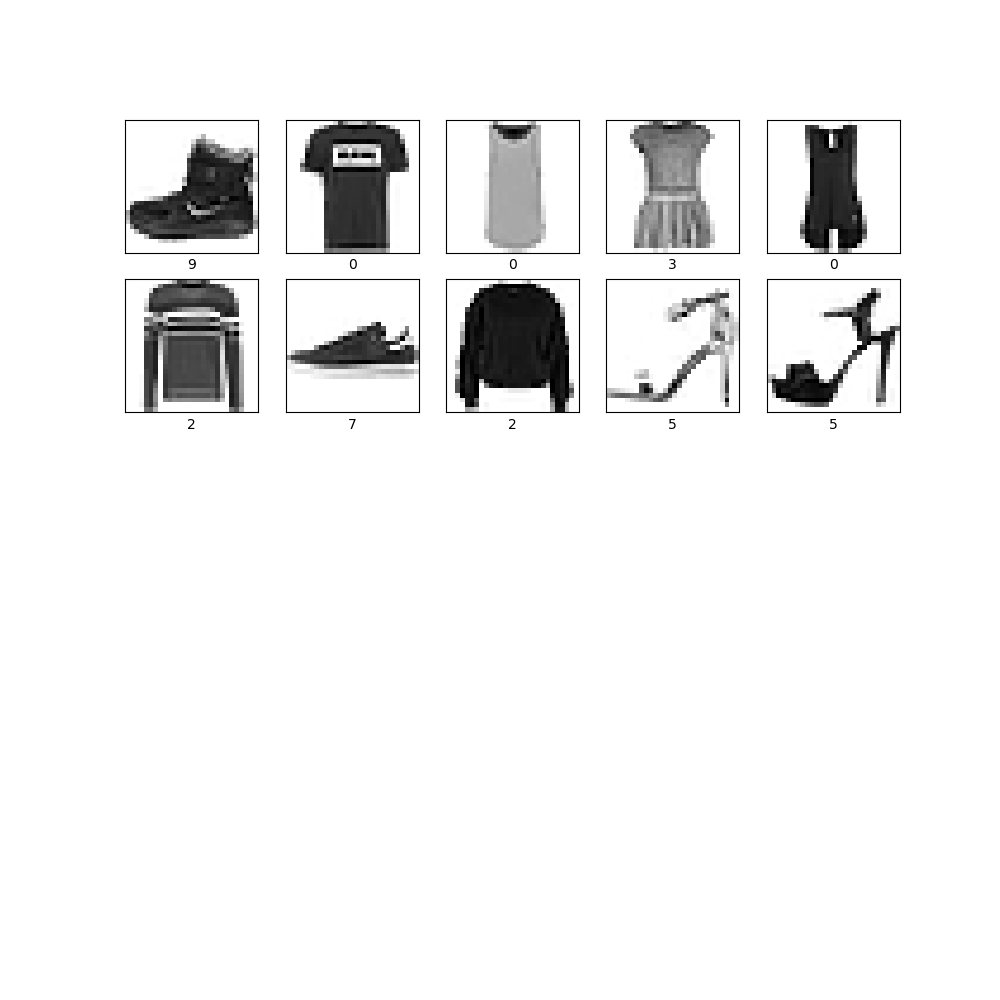

In [4]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])



## Understanding Data Geometry

In [5]:
X_train_sub = X_train[:10000]

In [6]:
X_train_sub = X_train_sub.reshape(10000, 28*28)

### Linear

In [7]:
lin_pca = decomposition.PCA(n_components=3)
X_train_pca = lin_pca.fit_transform(X_train_sub)
X_train_pca.shape


(10000, 3)

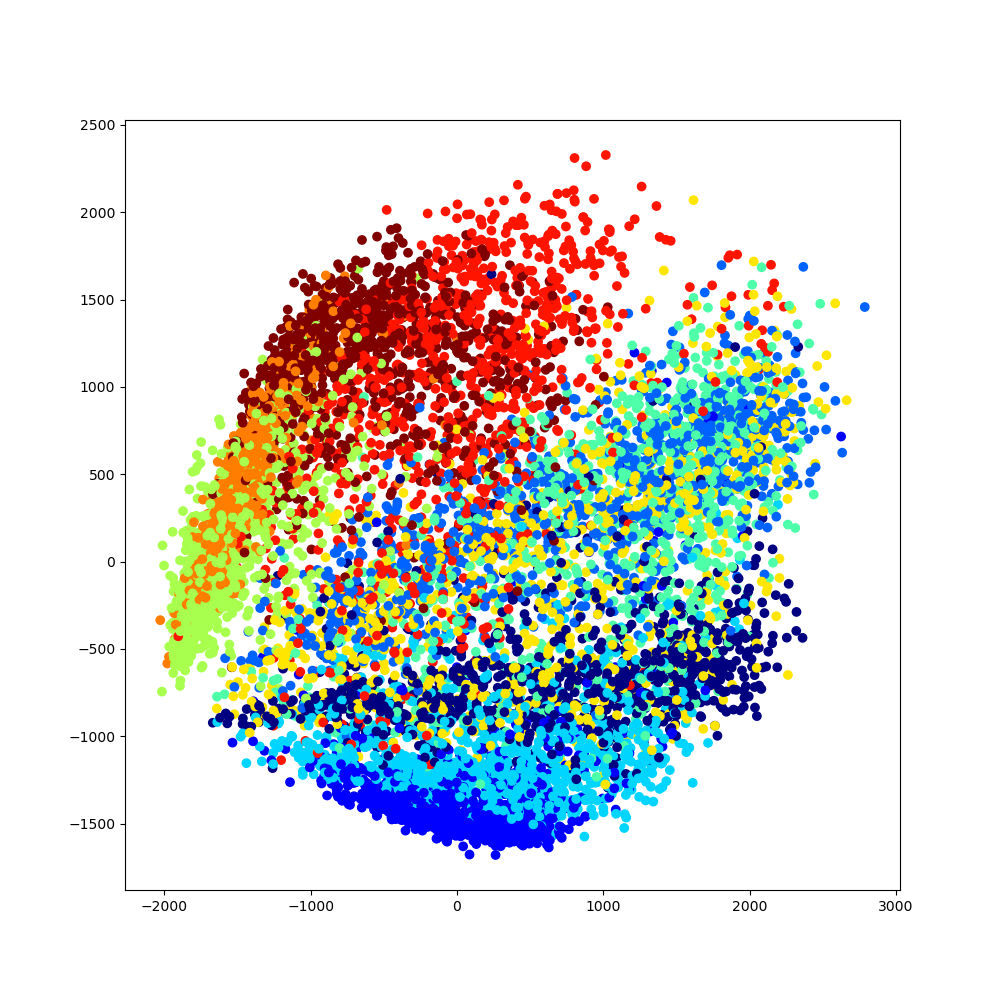

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train[:10000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()

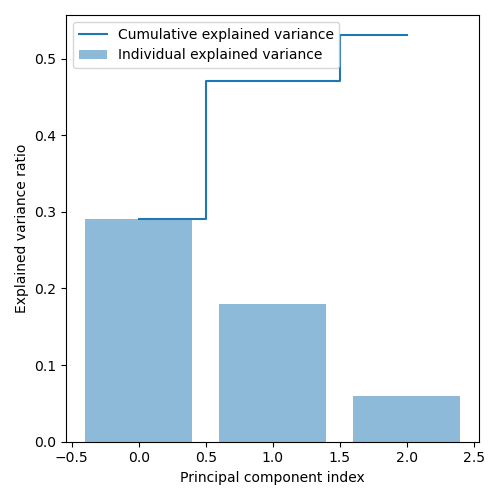

In [9]:
cum_sum_eigenvalues = np.cumsum(lin_pca.explained_variance_ratio_)
plt.figure(figsize=(5, 5))
plt.bar(range(0,len(lin_pca.explained_variance_ratio_)), lin_pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### Kernel PCA

#### RBF PCA

In [29]:
rbf_pca = decomposition.KernelPCA(n_components=3, kernel='rbf', gamma=0.1)
X_train_rbf_pca = rbf_pca.fit_transform(X_train_sub)
X_train_rbf_pca.shape


(10000, 3)

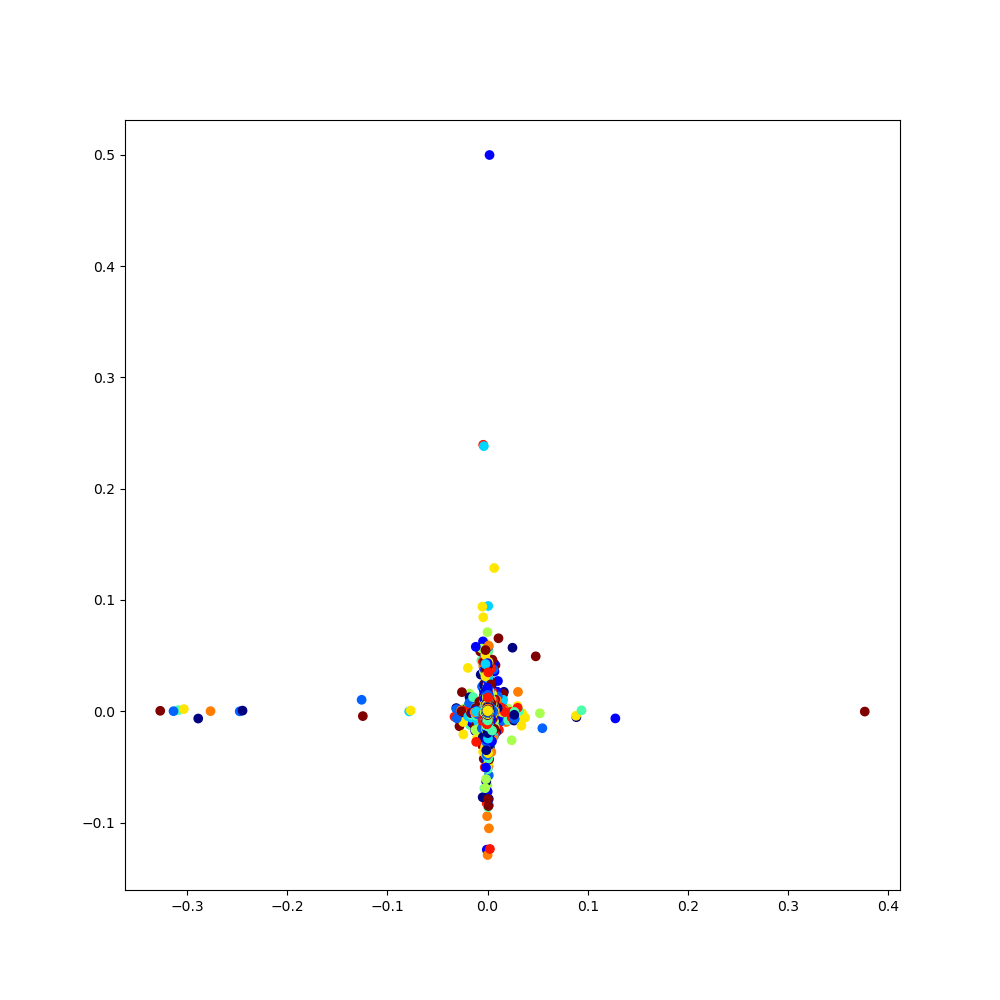

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train_rbf_pca[:, 1], X_train_rbf_pca[:, 2], c=y_train[:10000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()

In [12]:
rbf_pca.eigenvalues_

array([1., 1., 1.])

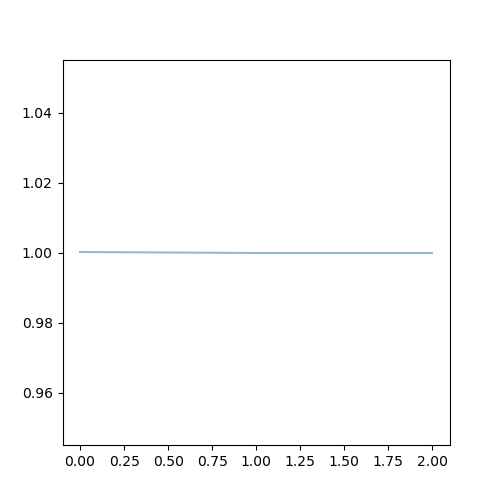

In [13]:
plt.figure(figsize=(5, 5))
plt.plot(range(0,len(rbf_pca.eigenvalues_)), rbf_pca.eigenvalues_, alpha=0.5, label='Individual explained variance')
plt.show()

#### Polynomial Kernel

In [19]:
poly_pca = decomposition.KernelPCA(n_components=3, kernel='sigmoid', degree=4)
X_train_poly_pca = poly_pca.fit_transform(X_train_sub)
X_train_poly_pca.shape

(10000, 3)

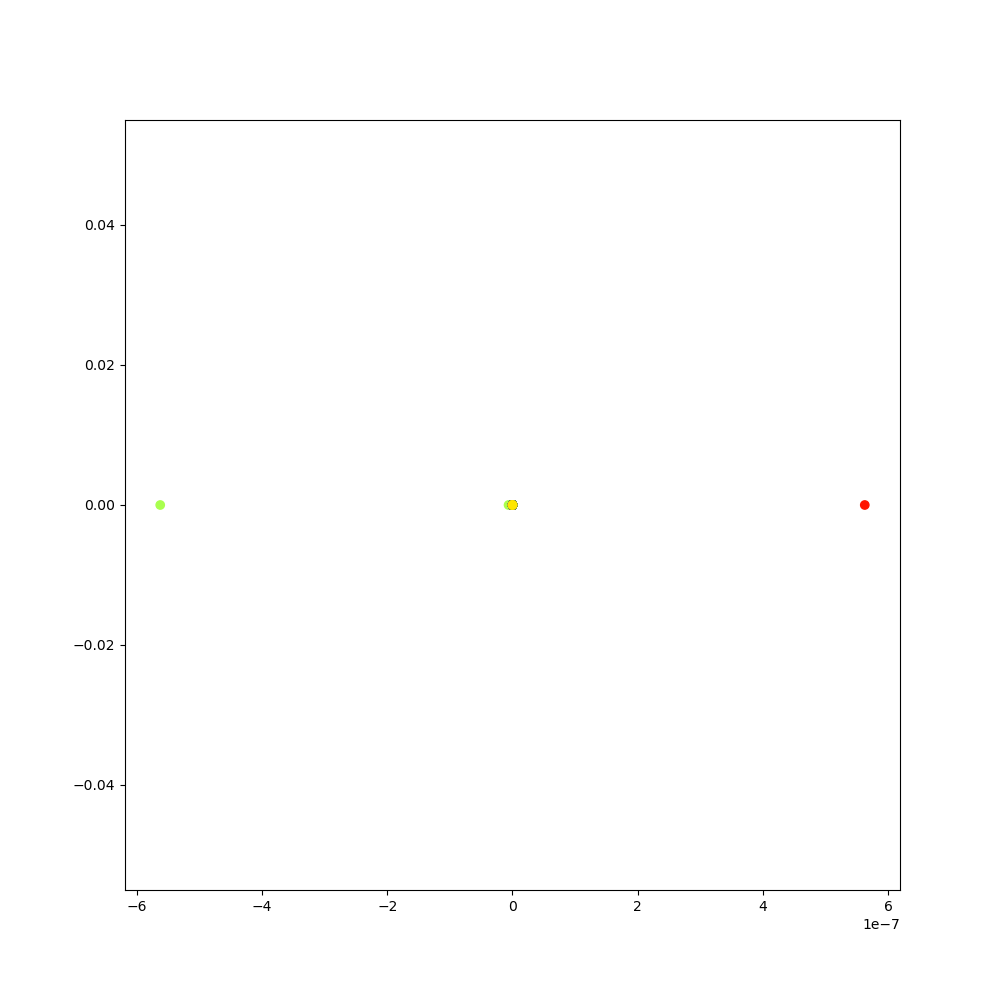

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train_poly_pca[:, 0], X_train_poly_pca[:, 1], c=y_train[:10000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()

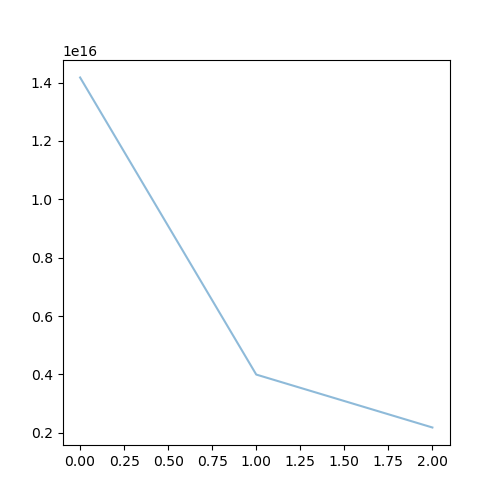

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(range(0,len(poly_pca.eigenvalues_)), poly_pca.eigenvalues_, alpha=0.5, label='Individual explained variance')
plt.show()

#### Custom kernel

In [ ]:
from scipy.linalg import eigh

In [24]:
def nu_quadratic_kernel(x1, x2):
    ret = np.dot(x1, x2)+1.0
    return ret ** 2

In [25]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-np.dot( x1-x2, x1-x2)/(2*sigma**2))

In [26]:
def prod_kernel(x1, x2, sigma):
    return nu_quadratic_kernel(x1, x2) * gaussian_kernel(x1, x2, sigma)

In [30]:
def kpca(x_data, gamma, n_components):
    """
    Implementation of a RBF kernel PCA.

    Arguments:
        x_data: A MxN dataset as NumPy array where the samples are stored as rows (M),
           and the attributes defined as columns (N).
        gamma: The free parameter (coefficient) for the RBF kernel.
        n_components: The number of components to be returned.

    """
    gram = np.vstack([np.asarray([gaussian_kernel(j,i,2/gamma) for i in x_data]) for j in x_data])
    N = gram.shape[0]
    one_n = np.ones((N,N)) / N
    gram = gram - one_n.dot(gram) - gram.dot(one_n) + one_n.dot(gram).dot(one_n)
    eigvals, eigvecs = eigh(gram)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    xpcs = np.column_stack([eigvecs[:, i] for i in range(n_components)])
    return xpcs

In [32]:
x_kpca = kpca(X_train_sub, gamma=5, n_components=2)

plt.scatter(x_kpca[:,0],x_kpca[:,1], c = y_train[:10000], cmap=plt.cm.get_cmap('jet', 10))

/tmp/ipykernel_19154/445394291.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(-np.dot( x1-x2, x1-x2)/(2*sigma**2))


KeyboardInterrupt: 

## Bridging *unsupervised* and *supervised*

In [17]:
poly_pca = decomposition.KernelPCA(n_components=10, kernel='poly', alpha=0.1)
X_train_poly_pca = poly_pca.fit_transform(X_train_sub)
X_train_poly_pca.shape


(10000, 10)

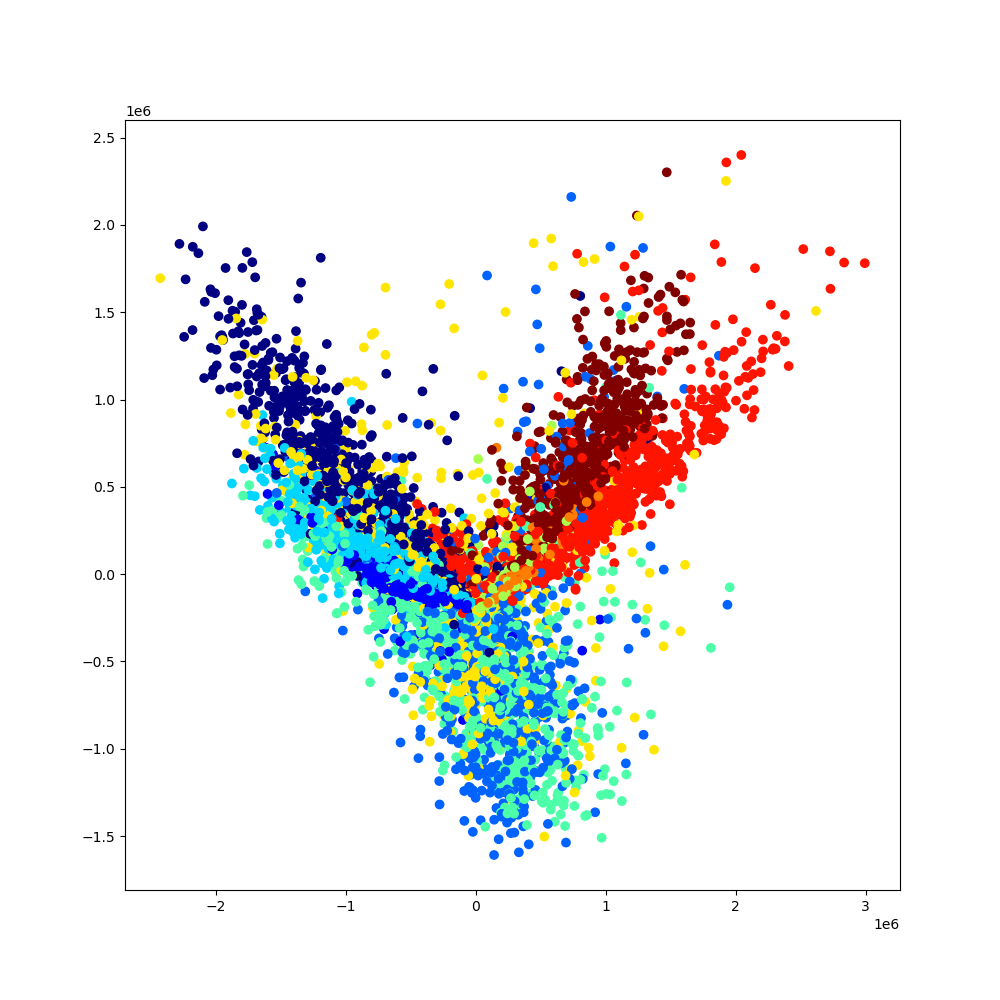

In [18]:
plt.figure(figsize=(10, 10))
plt.scatter(X_train_poly_pca[:, 1], X_train_poly_pca[:, 2], c=y_train[:10000], cmap=plt.cm.get_cmap('jet', 10))
plt.show()

In [19]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=10, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X_train_sub)


In [20]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(y_train[:10000], y_km)

0.5030122164632176

## (Supervised) classification

how should I asses performance???

In [21]:
training_data_fake = copy.deepcopy(training_data)
training_data_fake.data = training_data_fake.data[:10000]
training_data_fake.targets = torch.from_numpy(y_km)

In [22]:
# Loading the datasets
train_loader = DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

NameError: name 'BATCH_SIZE' is not defined

### SVM

In [ ]:
from sklearn.svm import SVC
svm_list = []
for i in range(10):
    tmp = [int(i==j) for j in y_km ]
    np.asarray(tmp)
    tmp_svm = SVC(kernel='poly', degree=3, coef0=1, C=5)
    tmp_svm.fit(X_train_sub, tmp)
    print(tmp_svm.score(X_train_sub, tmp))
    svm_list.append(tmp_svm)

1.0
1.0
1.0
1.0
1.0
1.0
0.9999
1.0
1.0
1.0


### MLP

In [ ]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_batch_accuracy(logit, target, map_index=None):
    """Obtain accuracy for one batch of data"""
    if map_index is not None:
        logit = logit[:,list(map_index.values())]
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

In [ ]:
class FNet(nn.Module):
        def __init__(self):
                super(FNet,self).__init__()
                hidden_1 = 512
                hidden_2 = 512
                self.fc1 = nn.Linear(28*28, 512)
                self.fc2 = nn.Linear(512,512)
                self.fc3 = nn.Linear(512,10)
                self.droput = nn.Dropout(0.2)

        def forward(self,x):
                x = x.view(-1,28*28)
                x = F.relu(self.fc1(x))
                x = self.droput(x)
                x = F.relu(self.fc2(x))
                x = self.droput(x)
                x = F.softmax(self.fc3(x))
               
                return x


In [ ]:
model_f = FNet()
model_f = model_f.to(device) 

In [ ]:
num_epochs = 5  # Number of times the whole (training) dataset is used for training
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model_f.parameters(), lr=learning_rate)

In [ ]:
train_loss = []
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model_f.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_f(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_f.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

### LeNet

In [ ]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 0.01
MOMENTUM = 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class LeNet(Module):
    def __init__(self, numChannels, classes):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        output = self.logSoftmax(x)
        return output

In [ ]:
model_l = LeNet(1,10)
model_l = model_l.to(device) 

In [ ]:
num_epochs = 5  # Number of times the whole (training) dataset is used for training
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model_l.parameters(), lr=learning_rate)

In [ ]:
train_loss = []
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model_l.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_l(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_l.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

 20%|██        | 1/5 [00:09<00:37,  9.39s/it]

Epoch: 1 | Loss: 0.5027746635001141 | Train Accuracy: 81.62686766275347


 40%|████      | 2/5 [00:18<00:27,  9.21s/it]

Epoch: 2 | Loss: 0.31684609815844095 | Train Accuracy: 88.43216382070437


 60%|██████    | 3/5 [00:27<00:18,  9.15s/it]

Epoch: 3 | Loss: 0.2697746790508196 | Train Accuracy: 90.17142475987193


 80%|████████  | 4/5 [00:37<00:09,  9.40s/it]

Epoch: 4 | Loss: 0.23831711878469303 | Train Accuracy: 91.35205442902881


100%|██████████| 5/5 [00:46<00:00,  9.35s/it]

Epoch: 5 | Loss: 0.21393143371733556 | Train Accuracy: 92.18082977588047


##  Wrap-up!

In [ ]:
tmp_counter = np.zeros(10)
map_index = {}
for j in range(10):
    tmp_counter = np.zeros(10)
    for i in range(10000):
        if y_km[i] == j:
            tmp_counter[y_train[i]] += 1
    map_index[j] = np.argmax(tmp_counter)


### testing svm

In [ ]:
test_acc = 0.0
for i, (images,labels) in enumerate(zip(X_test, y_test)):
    #images = images.to(device)
    #labels = labels.to(device)
    images = images.reshape(1,28*28)
    labels = map_index[labels]
    list_pred = np.asarray([svm_list[j].predict(images) for j in range(10)])
    wrong = np.sum(list_pred)-1 if list_pred[labels] == 1 else np.sum(list_pred)
    test_acc += (len(list_pred)-wrong)/len(list_pred)
print(f"Test Accuracy: {test_acc/i}")

### testing mlp

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    logits = model_f(images)
    test_acc += get_batch_accuracy(logits, labels, map_index=map_index)
print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 25.010016025641026


### testing cnn

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    logits = model_l(images)
    test_acc += get_batch_accuracy(logits, labels, map_index=map_index)
print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 25.010016025641026


## A *fully-supervised* approach

### SVM

In [ ]:
svm_list_s = []
for i in range(10):
    tmp = [int(i==j) for j in y_km ]
    np.asarray(tmp)
    tmp_svm = SVC(kernel='poly', degree=3, coef0=1, C=5)
    tmp_svm.fit(X_train_sub, tmp)
    print(tmp_svm.score(X_train_sub, tmp))
    svm_list_s.append(tmp_svm)

In [ ]:
test_acc = 0.0
for i, (images,labels) in enumerate(zip(X_test, y_test)):
    images = images.reshape(1,28*28)
    labels = map_index[labels]
    list_pred = np.asarray([svm_list_s[j].predict(images) for j in range(10)])
    wrong = np.sum(list_pred)-1 if list_pred[labels] == 1 else np.sum(list_pred)
    test_acc += (len(list_pred)-wrong)/len(list_pred)
print(f"Test Accuracy: {test_acc/i}")

### MLP

In [ ]:
model_fs = FNet()
model_fs = model_fs.to(device) 

In [ ]:
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model_fs.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_fs(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_fs.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    logits = model_fs(images)
    test_acc += get_batch_accuracy(logits, labels)
print(f"Test Accuracy: {test_acc/i}")

### CNN

In [ ]:
model_ls = LeNet(1,10)
model_ls = model_ls.to(device) 

In [ ]:
train_loss = []
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model_ls.train()  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model_ls(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model_ls.eval()
    print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}")
    train_loss.append(train_running_loss)

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    logits = model_ls(images)
    test_acc += get_batch_accuracy(logits, labels)
print(f"Test Accuracy: {test_acc/i}")